In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd

# -----------------------------
# (a) Generate a synthetic speech signal using Source-Filter Model
# -----------------------------
duration = 1.0          # seconds
fs_ref = 44100          # reference sampling rate (Hz)
t = np.linspace(0, duration, int(fs_ref*duration), endpoint=False)

# (i) Create a source signal: voiced (glottal pulses) + unvoiced (noise)
f0 = 120.0  # fundamental frequency (Hz)
period = int(fs_ref / f0)
impulses = np.zeros_like(t)
voiced_len = int(0.6 * fs_ref)
impulses[:voiced_len][::period] = 1.0

# Glottal pulse shape (approximation)
pulse_len = int(fs_ref * 0.003)  # 3 ms
glottal_pulse = (1 - np.cos(2*np.pi*np.linspace(0, 1, pulse_len))) * np.exp(-np.linspace(0, 3, pulse_len))
source_voiced = np.convolve(impulses, glottal_pulse, mode='same')

# Add unvoiced noise for the last 0.4s
noise = np.random.randn(len(t)) * 0.05
source = source_voiced.copy()
source[voiced_len:] = noise[voiced_len:]
source /= np.max(np.abs(source) + 1e-12)

# (ii) Apply a filter modeling the vocal tract (formants)
formants = [(700, 80), (1220, 90), (2600, 120)]  # example: vowel /a/
a = np.array([1.0])
for (f, bw) in formants:
    w = 2 * np.pi * f / fs_ref
    r = np.exp(-np.pi * bw / fs_ref)
    a_section = np.array([1.0, -2*r*np.cos(w), r**2])
    a = np.convolve(a, a_section)
speech = signal.lfilter([1.0], a, source)
speech /= np.max(np.abs(speech) + 1e-12)


In [2]:
%pip install pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 14.8 MB/s  0:00:00m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.


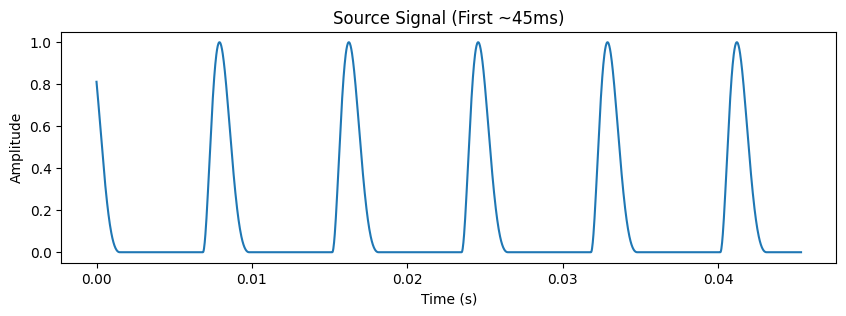

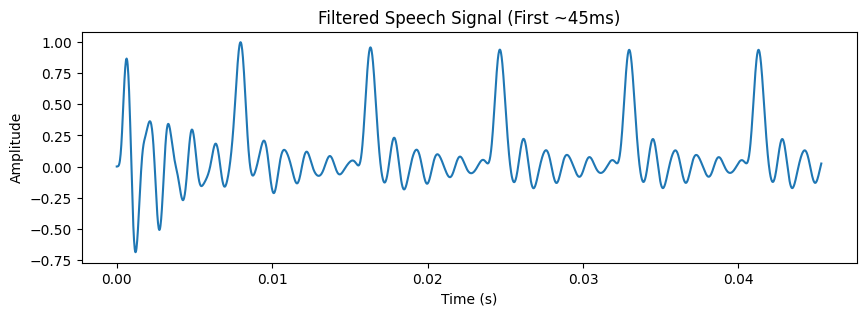

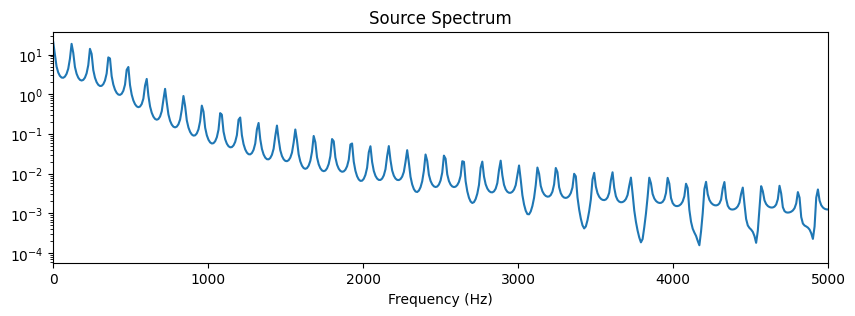

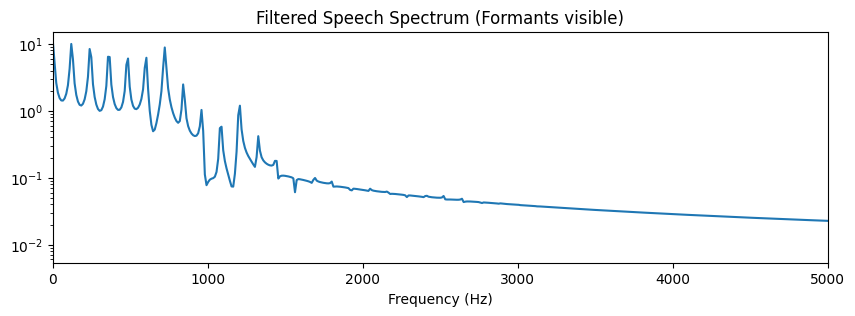

In [4]:

# -----------------------------
# (b) Plot source and filtered signal
# -----------------------------
plt.figure(figsize=(10, 3))
plt.plot(t[:2000], source[:2000])
plt.title("Source Signal (First ~45ms)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t[:2000], speech[:2000])
plt.title("Filtered Speech Signal (First ~45ms)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Frequency response (showing formant effects)
N_fft = 4096
f_axis = np.linspace(0, fs_ref/2, N_fft//2)
S = np.fft.rfft(source * np.hanning(len(source)), n=N_fft)
Y = np.fft.rfft(speech * np.hanning(len(speech)), n=N_fft)
plt.figure(figsize=(10, 3))
plt.semilogy(f_axis, np.abs(S)[:N_fft//2] + 1e-12)
plt.title("Source Spectrum")
plt.xlabel("Frequency (Hz)")
plt.xlim(0, 5000)
plt.show()

plt.figure(figsize=(10, 3))
plt.semilogy(f_axis, np.abs(Y)[:N_fft//2] + 1e-12)
plt.title("Filtered Speech Spectrum (Formants visible)")
plt.xlabel("Frequency (Hz)")
plt.xlim(0, 5000)
plt.show()



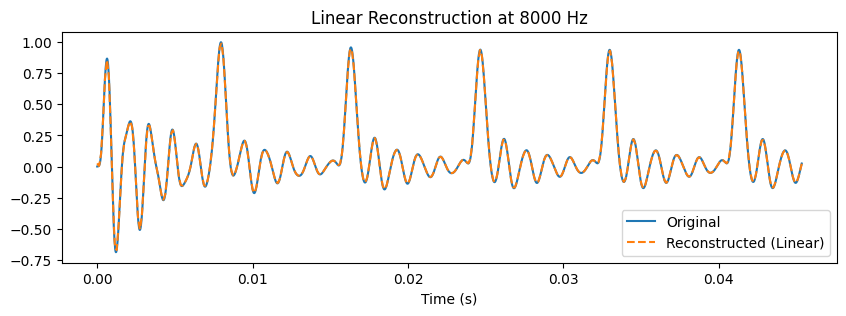

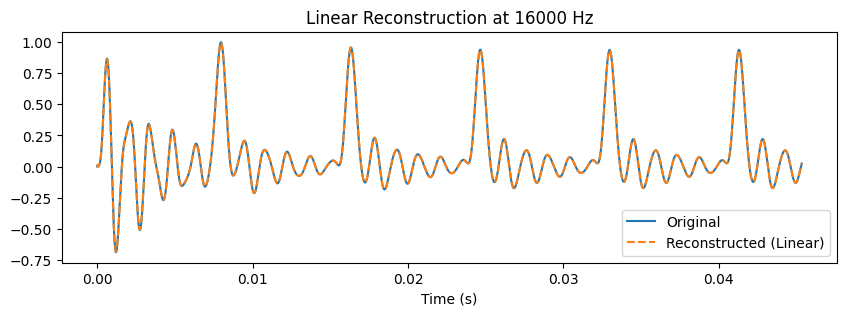

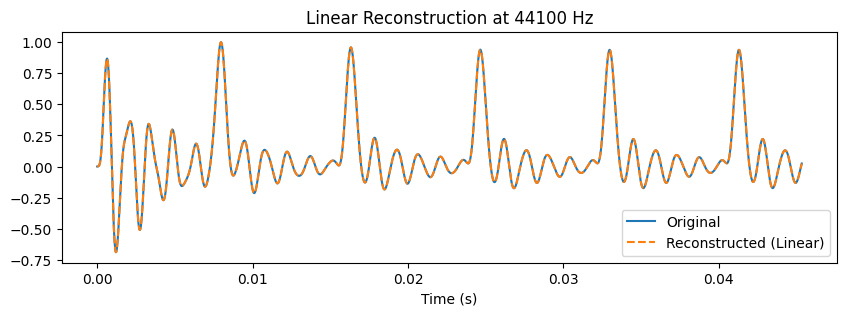

   Sampling Rate (Hz)     MSE (ZOH)  MSE (Linear)
0                8000  1.412138e-05  1.412138e-05
1               16000  9.102755e-07  9.102755e-07
2               44100  9.506017e-33  9.506017e-33


'\nInference:\n1. The source-filter model successfully generates a voiced + unvoiced speech-like sound.\n   - The source provides the excitation (glottal pulses or noise).\n   - The filter adds resonant formants representing the vocal tract.\n\n2. As sampling rate decreases:\n   - High-frequency components (formants) are lost due to aliasing.\n   - The speech sounds muffled or distorted.\n\n3. During reconstruction:\n   - Zero-Order Hold causes staircase artifacts.\n   - Linear interpolation gives smoother reconstruction but cannot recover lost high-frequency details.\n\n4. MSE increases as sampling rate decreases, confirming degradation in signal fidelity.\n'

In [5]:
# -----------------------------
# (c) Sampling at different rates
# -----------------------------
sample_rates = [8000, 16000, 44100]
mse_results = []

for fs_s in sample_rates:
    n_s = int(duration * fs_s)
    sampled = signal.resample(speech, n_s)
    t_s = np.linspace(0, duration, n_s, endpoint=False)

    # -----------------------------
    # (d) Reconstruction using ZOH and Linear interpolation
    # -----------------------------
    t_ref = np.linspace(0, duration, len(speech), endpoint=False)

    # Zero-Order Hold (nearest neighbor)
    recon_zoh = np.interp(t_ref, t_s, sampled, left=sampled[0], right=sampled[-1])

    # Linear interpolation
    recon_linear = np.interp(t_ref, t_s, sampled)

    # -----------------------------
    # (e) Compute MSE
    # -----------------------------
    mse_zoh = np.mean((speech - recon_zoh)**2)
    mse_linear = np.mean((speech - recon_linear)**2)

    mse_results.append({
        'Sampling Rate (Hz)': fs_s,
        'MSE (ZOH)': mse_zoh,
        'MSE (Linear)': mse_linear
    })

    # Plot sample comparison
    plt.figure(figsize=(10,3))
    plt.plot(t[:2000], speech[:2000], label="Original")
    plt.plot(t[:2000], recon_linear[:2000], '--', label="Reconstructed (Linear)")
    plt.title(f"Linear Reconstruction at {fs_s} Hz")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.show()

# -----------------------------
# Display MSE results
# -----------------------------
df = pd.DataFrame(mse_results)
print(df)

# -----------------------------
# (f) Inference
# -----------------------------
"""
Inference:
1. The source-filter model successfully generates a voiced + unvoiced speech-like sound.
   - The source provides the excitation (glottal pulses or noise).
   - The filter adds resonant formants representing the vocal tract.

2. As sampling rate decreases:
   - High-frequency components (formants) are lost due to aliasing.
   - The speech sounds muffled or distorted.

3. During reconstruction:
   - Zero-Order Hold causes staircase artifacts.
   - Linear interpolation gives smoother reconstruction but cannot recover lost high-frequency details.

4. MSE increases as sampling rate decreases, confirming degradation in signal fidelity.
"""
